# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# 1. Data Loading and Preprocessing


In [4]:
data_dir = '/Users/advait/Downloads/images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [5]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    zoom_range=0.2, 
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# 2. EDA (Visualizing Some Images)


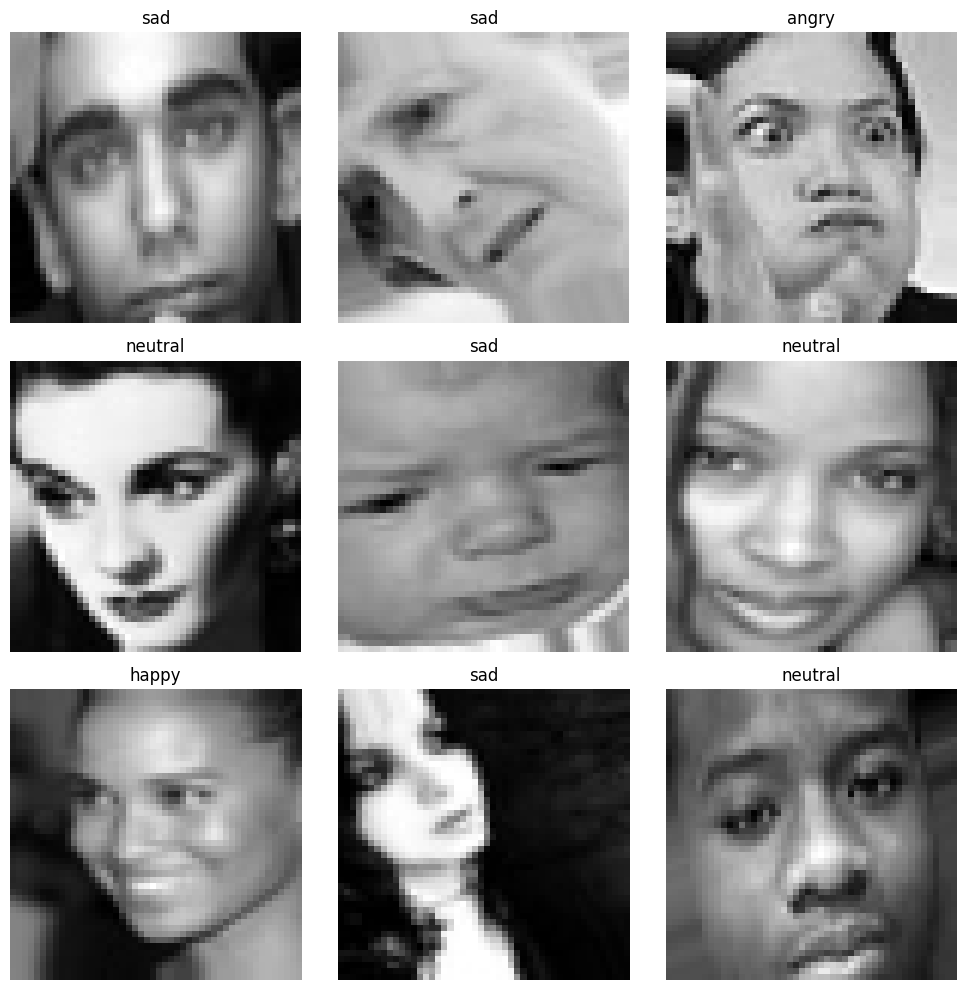

In [6]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3. CNN Model Architecture

In [8]:
# 3. CNN Model Architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_4 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_5 (Bat  (None, 21, 21, 128)      

# 4. Model Training


In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Model Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
451/451 [==============================] - 74s 162ms/step - loss: 2.0892 - accuracy: 0.2805 - val_loss: 2.2521 - val_accuracy: 0.2635 - lr: 0.0010
Epoch 2/50
451/451 [==============================] - 83s 183ms/step - loss: 1.6323 - accuracy: 0.3787 - val_loss: 1.5165 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 3/50
451/451 [==============================] - 95s 212ms/step - loss: 1.4799 - accuracy: 0.4322 - val_loss: 1.6037 - val_accuracy: 0.4045 - lr: 0.0010
Epoch 4/50
451/451 [==============================] - 89s 198ms/step - loss: 1.4077 - accuracy: 0.4632 - val_loss: 1.4366 - val_accuracy: 0.4561 - lr: 0.0010
Epoch 5/50
451/451 [==============================] - 85s 188ms/step - loss: 1.3630 - accuracy: 0.4777 - val_loss: 1.3746 - val_accuracy: 0.4795 - lr: 0.0010
Epoch 6/50
451/451 [==============================] - 83s 183ms/step - loss: 1.3276 - accuracy: 0.4919 - val_loss: 1.4763 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 7/50
451/451 [==============================] 

# 6. Evaluation - Classification Report & Confusion Matrix

2/2 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

       angry       0.71      0.42      0.53        12
     disgust       1.00      0.50      0.67         2
        fear       0.20      0.20      0.20         5
       happy       0.87      0.81      0.84        16
     neutral       0.47      0.64      0.54        11
         sad       0.47      0.50      0.48        14
    surprise       0.67      1.00      0.80         4

    accuracy                           0.59        64
   macro avg       0.63      0.58      0.58        64
weighted avg       0.62      0.59      0.59        64



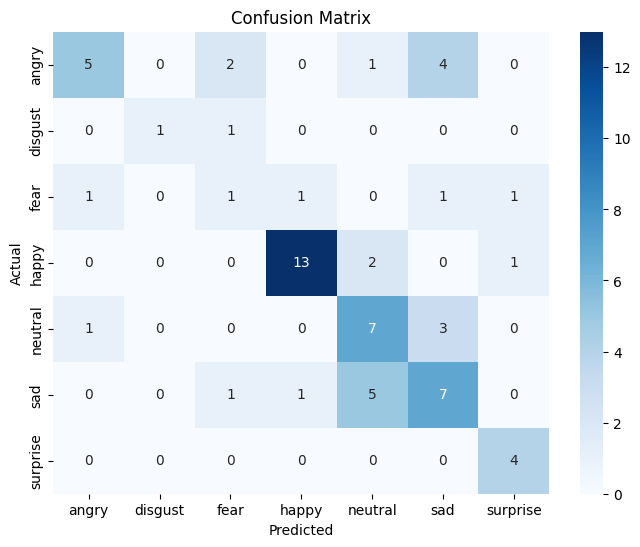

In [10]:
# 6. Evaluation - Classification Report & Confusion Matrix
val_images, val_labels = next(validation_generator)
predictions = model.predict(val_images)
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 7. Detection System


1/1 [==============================] - 0s 60ms/step


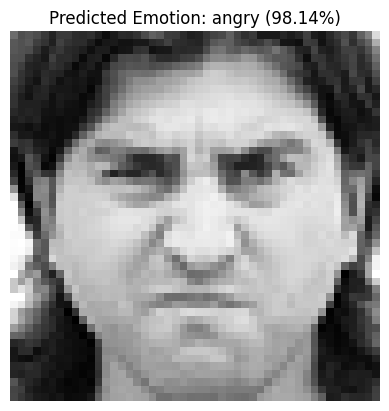

Emotion: angry, Confidence: 98.14%


In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def detect_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = round(prediction[0][predicted_index] * 100, 2)  # Confidence in %

    # Display the image with the predicted label and confidence
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Emotion: {predicted_class} ({confidence}%)')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Example Detection
predicted_emotion, confidence = detect_emotion('anger.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")


1/1 [==============================] - 0s 20ms/step


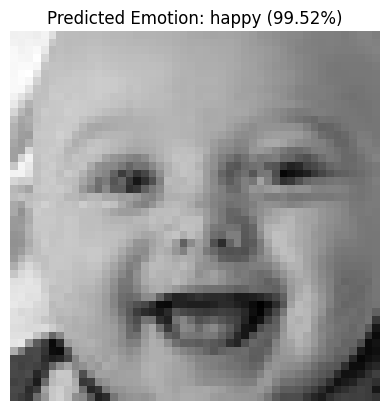

('happy', 99.52)


In [13]:
# Example Detection
print(detect_emotion('happy.jpg'))


1/1 [==============================] - 0s 18ms/step


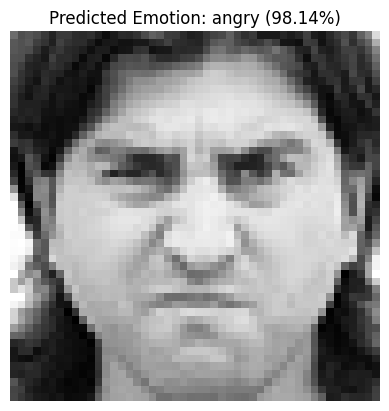

('angry', 98.14)


In [14]:
# Example Detection
print(detect_emotion('anger.jpg'))


1/1 [==============================] - 0s 18ms/step


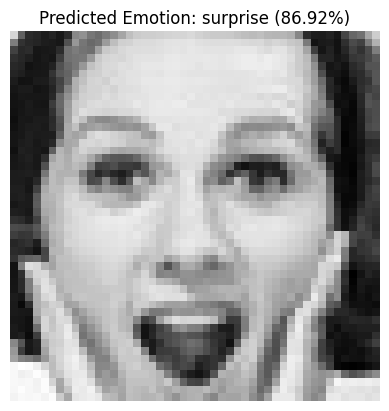

('surprise', 86.92)


In [16]:
# Example Detection
print(detect_emotion('surprise.jpg'))


# 8. Save Model


In [ ]:
# 8. Save Model
model.save('facial_emotion_detection_model.h5')

/Users/advait/Human-Facial-Emotions-Detection-Using-Deep-Learning-CNN-Python/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']